# News Article Matrix Factorization

---

Unsupervised topic modeling applied to BBC News articles.

The purpose of this project is to explore natural language processing techniques such as word token vectorization using Term Frequency-Inverse Document Frequency (TF-IDF) and utilizing unsupervised classification techniques such as Non-Negative Matrix Factorization (NMF). Analysis of models will also delve into differences in supervised and unsupervised models on randomly sliced proportions of the training set.

This project derives from the Kaggle competition with the name BBC News Classification, found here: https://www.kaggle.com/competitions/learn-ai-bbc/overview

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
  - 1.1. [Text Corpus](#data)
  - 1.2. [Kaggle Information](#kaggle)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Text Cleanup](#textclean)
  - 3.3. [Missing Data](#missingdata)
  - 3.4. [Checking for Duplicate Entries](#duplicates)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models and Embedding**](#models)
  - 5.1. [Baseline Models](#baseline)
  - 5.2. [Word Embedding](#embed)
  - 5.3. [Unsupervised Model](#unsuper)
    - 5.3.1. [Non-Negative Matrix Factorization (NMF)](#nmf)
  - 5.4. [Supervised Models](#super)
    - 5.4.1. [XGBoost](#xgb)
      - 5.4.1.1. [Feature Importance](#featimp)
    - 5.4.2. [Support Vector Machine (SVM)](#svm)
- 6.[**Comparison of Supervised / Unsupervised at Different Training Data Sizes**](#comparison)
- 7.[**Conclusion - Kaggle Test Set**](#conclusion)
  - 7.1.[Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Text Corpus: <a name="data"></a>

Public dataset of BBC articles.

**Data Info:**
- Accessed and obtained on 6/11/2024.
- 2225 BBC Articles
    - Training Set: 1490 Articles
    - Testing Set: 735 Articles
- 5 Article Classifications.
    - Business
    - Entertainment
    - Politics
    - Sport
    - Tech

- **Feature Information**
    - **ArticleID:** Unique indexing number.
    - **Text:** Full article stored as a string, no newline characters.
    - **Category:** Article category label.

### 1.2. Kaggle Information: <a name="kaggle"></a>

#### Description:

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

#### Evaluation:

The evaluation metric for this competition is Accuracy. Sample Solution FIle shows the format required for submission. The file should contain a header and have the following two columns ArticleId (from Test File) Category (one of the five categories - sport, tech, business, entertainment or politics)

#### Citation: 

Bijoy Bose. (2019). BBC News Classification. Kaggle. https://kaggle.com/competitions/learn-ai-bbc

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

import re
import itertools
from nltk.corpus import stopwords
# nltk.download('stopwords') # Needed for first run.

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import SVC
import xgboost as xgb

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [2]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, re, sklearn, xgb]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 're'  using version: 2.2.1
<module 'sklearn'  using version: 1.3.2
<module 'xgboost'  using version: 2.0.3


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [3]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [4]:
# Add and sort all filenames from each folder path.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
file_path = sorted(file_path)

# Iterate through filenames and add them to dataframe.
# pd.read_csv can unzip as it goes with compression argument.
train = pd.read_csv(data_folder + '/BBC News Train.csv.gz', compression = 'gzip')
X_test = pd.read_csv(data_folder + '/BBC News Test.csv.gz', compression = 'gzip')
sample_y_test = pd.read_csv(data_folder + '/BBC News Sample Solution.csv.gz', compression = 'gzip')

###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

Print out some basic information about the training and testing sets.

In [5]:
print('Train\n####################')
display(train)
print(train.dtypes)
print('\nTest\n####################')
print(X_test.columns.to_list())
print(X_test.shape)

Train
####################


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


ArticleId     int64
Text         object
Category     object
dtype: object

Test
####################
['ArticleId', 'Text']
(735, 2)


To keep all future plots clear and consistent, a color map dictionary will map article categories to a color. 

In [6]:
# Build custom color map for consistent label visualization.
category_cmap = {'business' : '#012A36',
                 'tech' : '#D16666',
                 'politics' : '#078060',
                 'sport' : '#29274C',
                 'entertainment' : '#FFF275'}

During any classification task, it is important to get a sense of how balance the class label distribution is among the data.

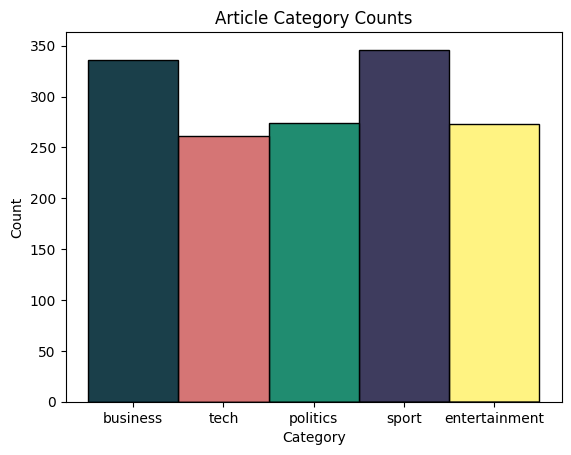

In [7]:
sns.histplot(train, x = 'Category', hue = 'Category', palette = category_cmap, legend = False, alpha = 0.9)
plt.title('Article Category Counts')
plt.show()

These are fairly even, no class balancing will be done for now.

Let's randomly sample a few articles to get a better idea what sort of text processing needs to be done before token vectorization. 

In [11]:
# Choose random text to display a section of.
print(train.Text[25][:200])
print(' -  -  - ')
print(train.Text[20][:200])
print(' -  -  - ')
print(train.Text[500][:200])

china had role in yukos split-up china lent russia $6bn (£3.2bn) to help the russian government renationalise the key yuganskneftegas unit of oil group yukos  it has been revealed.  the kremlin said o
 -  -  - 
hewitt overcomes wobble in sydney lleyton hewitt gave himself the perfect preparation for next week s australian open with victory over ivo minar in the final of the sydney international.  the defendi
 -  -  - 
gm in crunch talks on fiat future fiat will meet car giant general motors (gm) on tuesday in an attempt to reach agreement over the future of the italian firm s loss-making auto group.  fiat claims th


Initially we see a few special characters, a few double spaces, all lowercase letters, no apostrophes, and more. Next, the text will be processed to better prepare it for vectorization and model fitting.



###### [Back to Table of Contents](#toc)

### 3.2. Text Cleanup: <a name="textclean"></a>

We can see that while there looks to have been some text preprocessing already done, there are a few more steps to be taken before more exploratory data analysis can be done and then into word embedding.

**Pre-processing done already:**
1. All letters are lowercase.
2. Apostrophes have been removed (e.g. `from yukos  yugansk s former owner` and `for next week s australian open`).

However, these have only been observed from a small sample of the text, so will be checked to ensure this is the case in the entire corpus.

**Pre-processing to be done:**
1. Remove special characters.
2. Remove punctuation.
3. Remove extra spaces.
4. Remove "stop words" (e.g. `the`, `is`, `a`, `an`, `for`, etc).
5. Tokenize words (e.g. `amazingly few discotheques provide jukeboxes` $\rightarrow$ `[amazingly], [few], [discotheques], [provide], [jukeboxes]`).

**Optional Pre-processing (to be determined during model fine-tuning):**
1. Lammatize words, reducing words to their roots (e.g. `striking` $\rightarrow$ `strike` or `strikes` $\rightarrow$ `strike`).

*Note: As this project is intended for classification using matrix factorization, removing stop words, plurals, and punctuation poses little risk in negatively affecting the model's abilities. However, if semantics or other NLP applications were intended, much of sentence meaning can be lost without careful application of these techniques. Conversely though, including special characters such as "$" could increase accuracy in classifying certain categories.*

In [12]:
def clean_corpus(df, column):
    '''
    Takes an unprocessed dataframe of text and returns a "cleaned" version, removing hyphens, special characters, 
    extra white spaces, and stopwords (sourced from the nltk.corpus package). Each processing step creates a column
    which is a chain of changes from previous processing. Final processing is stored in "cleaned" column.
    Parameters:
        df: Dataframe of text to be processed.
        column: Column name of text.
    Returns:
        None: Processed text added to input dataframe.
    '''
    # Remove hyphens and replace with space.
    df['hyphen'] = df[column].apply(lambda x: re.sub(r'-', ' ', x))
    # Remove anything that isn't a latter, number, or space.
    df['alpha_only'] = df['hyphen'].apply(lambda x: re.sub(r'[^ a-zA-Z0-9]+', '', x))
    # Remove any extra spaces.
    df['extra_spaces'] = df['alpha_only'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
    # Remove stop words.
    stops = set(stopwords.words('english')) # Set lookup is faster.
    df['cleaned'] = df['extra_spaces'].apply(lambda x: ' '.join([word for word in x.split() if word not in stops]))
    
    return

Both training and test sets will be processed in the same manner.

In [13]:
# Apply text processing function.
clean_corpus(train, 'Text')
clean_corpus(X_test, 'Text')

Now let's see those same examples from earlier, but processed. 

Also, we can put the unprocessed and processed versions of a text into their each `set()` and perform subtraction to find the difference between the two -- showing the changes made.

In [14]:
print('Processed:', train.cleaned[25][:200])
print('Original: ', train.Text[25][:200])
print(' -  -  - ')
print('Processed:', train.cleaned[20][:200])
print('Original: ', train.Text[20][:200])
print(' -  -  - ')
print('Processed:', train.cleaned[500][:200])
print('Original: ', train.Text[500][:200])
print(' -  -  - \n -  -  - ')
print('Set Difference Example:', set(train.Text[25].split()) - set(train.cleaned[25].split()))

Processed: china role yukos split china lent russia 6bn 32bn help russian government renationalise key yuganskneftegas unit oil group yukos revealed kremlin said tuesday 6bn russian state bank veb lent state own
Original:  china had role in yukos split-up china lent russia $6bn (£3.2bn) to help the russian government renationalise the key yuganskneftegas unit of oil group yukos  it has been revealed.  the kremlin said o
 -  -  - 
Processed: hewitt overcomes wobble sydney lleyton hewitt gave perfect preparation next week australian open victory ivo minar final sydney international defending champion brushed aside czech qualifier 7 5 6 0 a
Original:  hewitt overcomes wobble in sydney lleyton hewitt gave himself the perfect preparation for next week s australian open with victory over ivo minar in the final of the sydney international.  the defendi
 -  -  - 
Processed: gm crunch talks fiat future fiat meet car giant general motors gm tuesday attempt reach agreement future italian firm los

This looks ready for the next steps.

Now that the text has been processed to the degree it has, tokenizing the words in the articles becomes trivial.

In [15]:
def tokenizer(df):
    df['tokens'] = df['cleaned'].apply(lambda x: x.split())
    
    return

In [16]:
tokenizer(train)
print(train.tokens[25][:25])

# Let's see how many articles have the word china within.
train.tokens[train.tokens.apply(lambda x: 'china' in x)]

['china', 'role', 'yukos', 'split', 'china', 'lent', 'russia', '6bn', '32bn', 'help', 'russian', 'government', 'renationalise', 'key', 'yuganskneftegas', 'unit', 'oil', 'group', 'yukos', 'revealed', 'kremlin', 'said', 'tuesday', '6bn', 'russian']


2       [bbc, poll, indicates, economic, gloom, citize...
17      [hantuchova, dubai, last, eight, daniela, hant...
25      [china, role, yukos, split, china, lent, russi...
32      [china, continues, rapid, growth, china, econo...
46      [china, ripe, media, explosion, asia, set, dri...
                              ...                        
1371    [gadget, growth, fuels, eco, concerns, technol...
1375    [musicians, tackle, us, red, tape, musicians, ...
1382    [yukos, seeks, court, action, sale, yukos, ret...
1417    [ticking, budget, facing, us, budget, proposal...
1461    [speech, takes, search, engines, scottish, fir...
Name: tokens, Length: 62, dtype: object

In [14]:
tokenizer(X_test)

###### [Back to Table of Contents](#toc)

### 3.3. Missing Data: <a name="missingdata"></a>

Another check on the processing step is to check if there are any tokens that are empty whitespace. These should have been dealt with during one of the regex preprocessing steps.

In [15]:
# Check to ensure no empty tokens.
train.tokens[train.tokens.apply(lambda x: ' ' in x)]

Series([], Name: tokens, dtype: object)

Now, we should ensure there aren't any articles with missing data.

In [16]:
train.isna().sum()

ArticleId       0
Text            0
Category        0
hyphen          0
alpha_only      0
extra_spaces    0
cleaned         0
tokens          0
dtype: int64

In [17]:
display(X_test.isna().sum())

ArticleId       0
Text            0
hyphen          0
alpha_only      0
extra_spaces    0
cleaned         0
tokens          0
dtype: int64

###### [Back to Table of Contents](#toc)

### 3.4. Checking for Duplicate Entries: <a name="duplicates"></a>

Finally, we need to ensure there aren't any duplicate entries in the data.

In [18]:
# Training Set
print('Duplicates Found:', train.Text.duplicated().sum())
print('DF Shape:', train.shape)

drop_idx = train[train.Text.duplicated()].index
train = train.drop(drop_idx, axis = 0)

print('Duplicates Found:', train.Text.duplicated().sum())
print('DF Shape:', train.shape)

Duplicates Found: 50
DF Shape: (1490, 8)
Duplicates Found: 0
DF Shape: (1440, 8)


50 articles are showing up as being duplicates in the training data. These have now been removed.

In [19]:
# Test
print('Duplicates Found:', X_test.Text.duplicated().sum())
print('DF Shape:', X_test.shape)

X_test[X_test.Text.duplicated()]

Duplicates Found: 13
DF Shape: (735, 7)


,ArticleId,Text,hyphen,alpha_only,extra_spaces,cleaned,tokens
213,1622,bookmakers back aviator for oscar the aviator ...,bookmakers back aviator for oscar the aviator ...,bookmakers back aviator for oscar the aviator ...,bookmakers back aviator for oscar the aviator ...,bookmakers back aviator oscar aviator tipped u...,"[bookmakers, back, aviator, oscar, aviator, ti..."
343,1865,latest opera browser gets vocal net browser op...,latest opera browser gets vocal net browser op...,latest opera browser gets vocal net browser op...,latest opera browser gets vocal net browser op...,latest opera browser gets vocal net browser op...,"[latest, opera, browser, gets, vocal, net, bro..."
444,719,apple attacked over sources row civil libertie...,apple attacked over sources row civil libertie...,apple attacked over sources row civil libertie...,apple attacked over sources row civil libertie...,apple attacked sources row civil liberties gro...,"[apple, attacked, sources, row, civil, liberti..."
451,895,brown ally rejects budget spree chancellor gor...,brown ally rejects budget spree chancellor gor...,brown ally rejects budget spree chancellor gor...,brown ally rejects budget spree chancellor gor...,brown ally rejects budget spree chancellor gor...,"[brown, ally, rejects, budget, spree, chancell..."
455,457,boothroyd calls for lords speaker betty boothr...,boothroyd calls for lords speaker betty boothr...,boothroyd calls for lords speaker betty boothr...,boothroyd calls for lords speaker betty boothr...,boothroyd calls lords speaker betty boothroyd ...,"[boothroyd, calls, lords, speaker, betty, boot..."
463,752,us blogger fired by her airline a us airline a...,us blogger fired by her airline a us airline a...,us blogger fired by her airline a us airline a...,us blogger fired by her airline a us airline a...,us blogger fired airline us airline attendant ...,"[us, blogger, fired, airline, us, airline, att..."
554,1246,howl helps boost japan s cinemas japan s box o...,howl helps boost japan s cinemas japan s box o...,howl helps boost japan s cinemas japan s box o...,howl helps boost japan s cinemas japan s box o...,howl helps boost japan cinemas japan box offic...,"[howl, helps, boost, japan, cinemas, japan, bo..."
599,887,blair backs pre-election budget tony blair h...,blair backs pre election budget tony blair h...,blair backs pre election budget tony blair h...,blair backs pre election budget tony blair has...,blair backs pre election budget tony blair bac...,"[blair, backs, pre, election, budget, tony, bl..."
621,237,kenyan school turns to handhelds at the mbita ...,kenyan school turns to handhelds at the mbita ...,kenyan school turns to handhelds at the mbita ...,kenyan school turns to handhelds at the mbita ...,kenyan school turns handhelds mbita point prim...,"[kenyan, school, turns, handhelds, mbita, poin..."
640,1420,millions buy mp3 players in us one in 10 adult...,millions buy mp3 players in us one in 10 adult...,millions buy mp3 players in us one in 10 adult...,millions buy mp3 players in us one in 10 adult...,millions buy mp3 players us one 10 adult ameri...,"[millions, buy, mp3, players, us, one, 10, adu..."


Interesting, there are also 13 duplicate articles in the testing set. Since the testing set will need to be submitted into Kaggle for scoring, we will be forced to leave them in.

###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

Now that the text has been processed, we are ready to perform EDA. Fortunately, now that the words have been tokenized EDA becomes much easier.

First, let's look at the total word counts and sort them by most frequent.

In [20]:
token_freq = train.explode('tokens').groupby(['tokens'], as_index=True)['tokens'].count().reset_index(
    name = 'frequency').sort_values('frequency', ascending = False)
token_freq.head(15)

,tokens,frequency
19814,said,4694
15376,mr,1896
24899,would,1652
25020,year,1485
2291,also,1366
15727,new,1299
16942,people,1244
23903,us,1222
16192,one,1199
6382,could,999


While interesting, not many of these stand out as being able to accurately categorize the articles. There are a few techniques later that will address this such as the `max_df` parameter during TF-IDF which will ignore words that show up in a threshold percentage of articles.

To get a slighly better view, we should plot the most frequent words to display more of them.

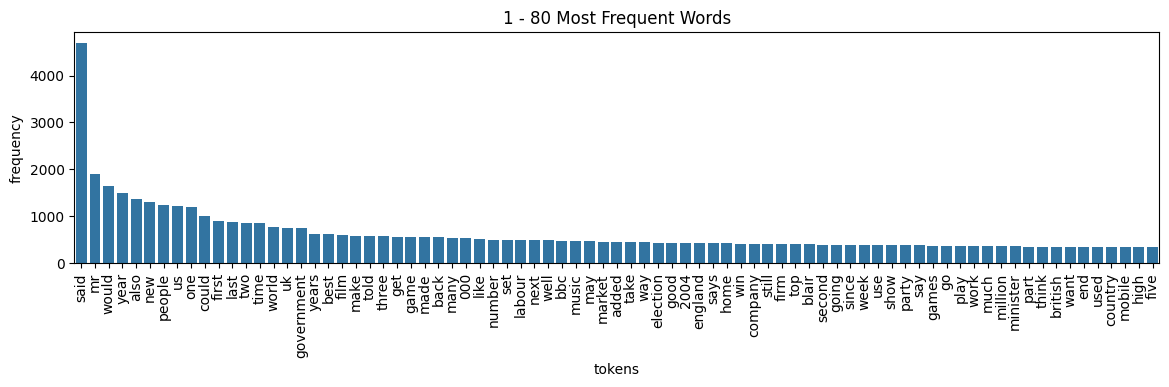

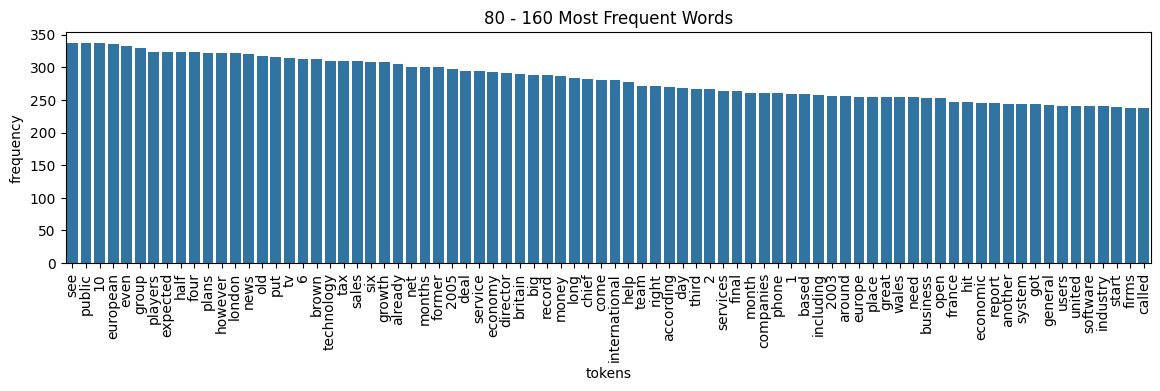

In [21]:
plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[0:79], x = 'tokens', y = 'frequency')
plt.title('1 - 80 Most Frequent Words')
plt.xticks(rotation = 90)
plt.show()

plt.subplots(figsize = (14, 3))
sns.barplot(token_freq[79:159], x = 'tokens', y = 'frequency')
plt.title('80 - 160 Most Frequent Words')
plt.xticks(rotation = 90)
plt.show()

These plots lead to deeper questions such as, can we show the proportion of each category whose articles contain these frequent words.

In [22]:
token_cat_freq = train.explode('tokens').groupby(['Category', 'tokens'], as_index=True)['tokens'].count().reset_index(name = 'frequency').sort_values('frequency', ascending = False)
token_cat_freq.head(15)

,Category,tokens,frequency
26912,politics,said,1412
7902,business,said,1098
25174,politics,mr,1038
45233,tech,said,980
28748,politics,would,685
35666,sport,said,628
44005,tech,people,578
17651,entertainment,said,576
13614,entertainment,film,551
9486,business,us,521


Now that we have sorted the words and grouped by category labels, we can plot a stacked bar chart.

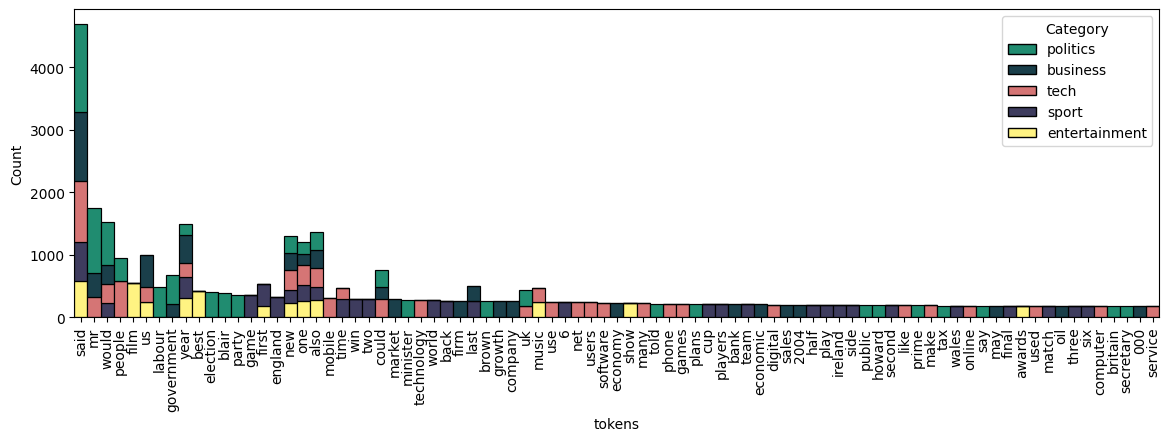

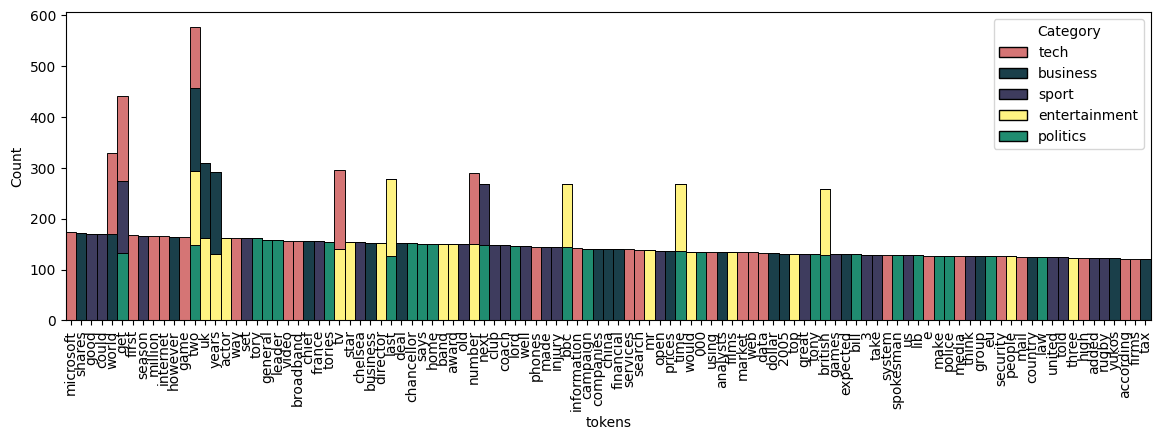

In [23]:
plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[0:119], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', palette = category_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

plt.subplots(figsize = (14, 4))
sns.histplot(token_cat_freq[119:239], x = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', palette = category_cmap, alpha = 0.9)
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.show()

This shows a much more detailed view of which words belong to which articles. Unsurprisingly some words only show up in one or two article types.

A few random examples of words that only show up in one article category:

- Business
    - Firm, Growth, Bank, Sales, Oil
- Entertainment
    - Best, Show, Actor, Star, Award
- Politics
    - Election, Blair, Party, Brown, Public
- Sport
    - Game, Win, Two, World, Players
- Tech
    - Mobile, Technology, Service, Microsoft, Phone

Since we intend to use TF-IDF, we need to take particular care to ensure article lengths distributions aren't too variable.

In [24]:
# Article lengths post tokenization.
train['article_len'] = train['tokens'].apply(lambda x: len(x))

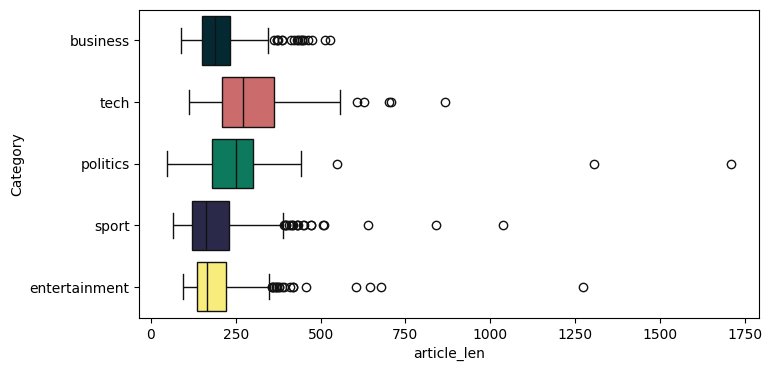

In [25]:
plt.subplots(figsize = (8, 4))
sns.boxplot(train, x = 'article_len', y = 'Category', hue = 'Category', palette = category_cmap, saturation = 0.9)
plt.show()

With the exception of a few outliers, article length distributions overlap fairly well.

Business, Entertainment, and Sport articles tend to be shorter, while Politics' distribution is wide, and Tech tend to be the longest.

For a bit of fun, let's implement something unique to text analysis, a word cloud.

In [26]:
# Create gradient color maps for each category to keep with the category color scheme.
# Each column in the array is RGB-Alpha values (in that order).
# RGB values are input as a fraction to fit between 0-1.
# Each row is the next value in the gradient, using linspace to go from each
# category's color to white (256,256,256,1)
# Unnecessary, probably, but looks great!

n = 256
# Business
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(1/256, 1, n)
vals[:, 1] = np.linspace(42/256, 1, n)
vals[:, 2] = np.linspace(54/256, 1, n)
cmp_business = ListedColormap(vals)

# Tech
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(209/256, 1, n)
vals[:, 1] = np.linspace(102/256, 1, n)
vals[:, 2] = np.linspace(102/256, 1, n)
cmp_tech = ListedColormap(vals)

# Politics
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(3/256, 1, n)
vals[:, 1] = np.linspace(64/256, 1, n)
vals[:, 2] = np.linspace(48/256, 1, n)
cmp_politics = ListedColormap(vals)

# Sport
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(41/256, 1, n)
vals[:, 1] = np.linspace(39/256, 1, n)
vals[:, 2] = np.linspace(76/256, 1, n)
cmp_sport = ListedColormap(vals)

# Entertainment
vals = np.ones((n, 4))
vals[:, 0] = np.linspace(161/256, 1, n)
vals[:, 1] = np.linspace(152/256, 1, n)
vals[:, 2] = np.linspace(72/256, 1, n)
cmp_entertainment = ListedColormap(vals)

# Create dictionary to call during plotting.
category_cmap_gradient = dict(zip(category_cmap.keys(), [cmp_business, cmp_tech, cmp_politics, cmp_sport, cmp_entertainment]))

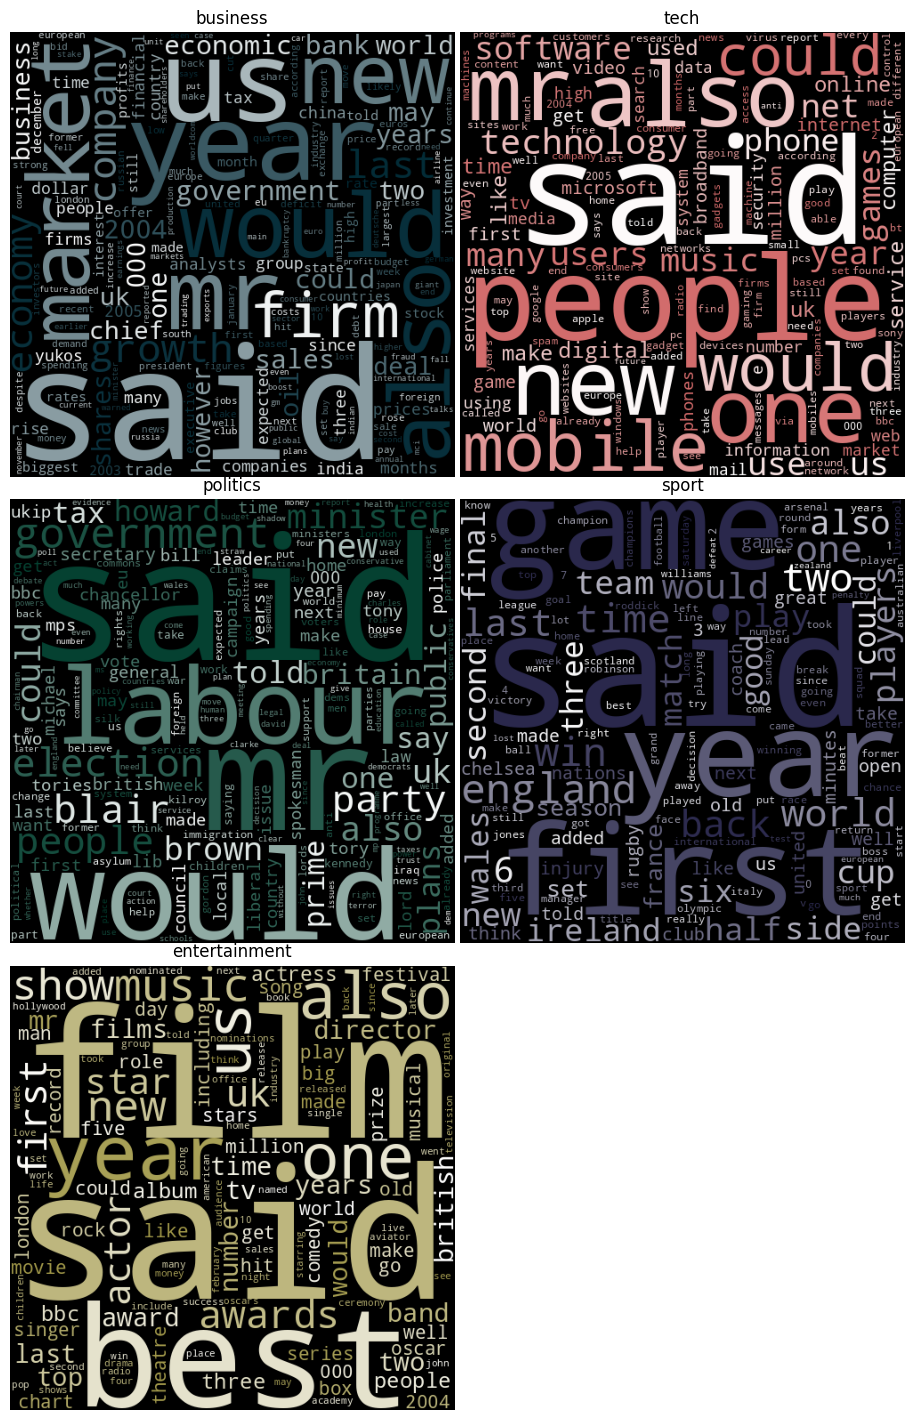

In [27]:
fig, ax = plt.subplots(3, 2, figsize = (9, 14), sharey = False, sharex = False)
for i, cat in enumerate(category_cmap.keys()):
    cloud = WordCloud(width = 500, height = 500, min_font_size = 8, colormap = category_cmap_gradient[cat])
    cloud.generate_from_frequencies(
        token_cat_freq[token_cat_freq['Category'] == cat][['tokens', 'frequency']].set_index('tokens').to_dict()['frequency'])
    ax[i//2, i%2].imshow(cloud)
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(cat)

fig.delaxes(ax[(2,1)])
plt.tight_layout(pad = 0)

Great! While, word clouds are certainly not the most quantitatively valuable in analysis, they sometimes help give a better general idea about word relationships in each category.

"Said", certainly takes center stage in all categories, but beyond that it's easy to find unique words in each category here indicating that this dataset may be a good candidate for unsupervised models.

*Note: Something else that might be interesting to implement is to remove words that all categories share at a certain threshold and only display the differences among their sets, but this is good enough for now.*

###### [Back to Table of Contents](#toc)

## 5. Models and Embedding <a name="models"></a>

---

### 5.1. Baseline Models <a name="baseline"></a>

The Kaggle source has already selected simple Accuracy as the metric to evaluate against. However, with any classification task, it is important to set a baseline model to compare all subsequently fit models against. 

The first baseline model is simple, equal random chance at selecting any of the article categories.

In [92]:
mod_rand_baseline = 1 / len(train.Category.unique()) # 1/5
print('Random Baseline Accuracy:', mod_rand_baseline)

Random Baseline Accuracy: 0.2


The next option is taking the most frequent class in the dataset and always predict that class.

*Note: The y predictions will be submitted to Kaggle to receive the accuracy score and posted here*

In [29]:
most_freq_cat = train.Category.value_counts(sort = True).index[0]
mod_freq_array = np.full(shape = len(X_test), fill_value = most_freq_cat)

y_pred_freq_baseline = X_test[['ArticleId']].copy()
y_pred_freq_baseline['Category'] = mod_freq_array
y_pred_freq_baseline.to_csv(current_wdir + f'/Models/Frequency_Baseline/X_test_Submission_Freq_Baseline.csv', index = False)
display(y_pred_freq_baseline)

mod_freq_baseline = 0.22448
print('Most Frequent Category Baseline Accuracy:', mod_freq_baseline)

,ArticleId,Category
0,1018,sport
1,1319,sport
2,1138,sport
3,459,sport
4,1020,sport
...,...,...
730,1923,sport
731,373,sport
732,1704,sport
733,206,sport


Most Frequent Category Baseline Accuracy: 0.22448


In this case it seems the most frequent article category in the training data is `sport`.

$\approx{22\%}$ Test Accuracy for predicting only the most frequent category in the training data is pretty reasonable for a simple baseline test. This result being within roughly 2% of the random chance baseline also indicates that the test set is fairly class balanced.

We will keep these accuracy scores in mind when evaluating the upcoming models.

###### [Back to Table of Contents](#toc)

### 5.2. Word Embedding <a name="embed"></a>

Next, we need a way to embed our corpus through a vectorization technique.

**Term Frequency-Inverse Document Frequency (TF-IDF):**

TF-IDF logarithmically scales an inverse fraction of number of documents divided by the number of documents containing each word. This effectively gives a measure of how much information each word holds in each document.

When fitting and transforming the training data into a TF-IDF sparse matrix, it needs to be mentioned that no test data text should be included in the fitting process. Like any other modeling process, this would constitute as data leakage and all evaluations would be meaningless. To ensure no data leakage occurs any time text data is being processed into a sparse matrix, the function `.transform()` (not `.fit_transform()`) will be used on a fitted TF-IDF object.

*Note: One issue that can potentially arise when using TF-IDF is if article lengths are highly variable, giving more weight to words contained in longer articles. However, as we saw during EDA this, mostly, shouldn't be the case in this dataset.*

In [30]:
def tf_vectorize(X_train, params):
    '''
    Takes a X_train dataframe and parameter grid to .fit_transform() the TfidVectorizer().
    Parameters:
        X_train: Dataframe of X training data.
        params: Dictionary of parameters in the form: {'Name':[Value]}
    Returns:
        tfidf: Fitted TF-IDF object.
        X_train_sparse: Transformed X_train into sparse matrix.
    '''
    tfidf = TfidfVectorizer(min_df = params['min_df'], # ignore terms that have a document frequency strictly LOWER than the given threshold
                            max_df = params['max_df'], # ignore terms that have a document frequency strictly HIGHER than the given threshold
                            norm = params['norm'], 
                            stop_words = None, # Already removed.
                            ngram_range = params['ngram_range'])
    # Fit and create sparse matrix.
    X_train_sparse = tfidf.fit_transform(X_train)

    return (tfidf, X_train_sparse)

###### [Back to Table of Contents](#toc)

### 5.3. Unsupervised Model <a name="unsuper"></a>

#### 5.3.1. Non-Negative Matrix Factorization (NMF) <a name="nmf"></a>

In NMF we take a non-negative value matrix ($\bf{V}$) and factorize it into two matrices, conventionally labeled $\bf{W}$ and $\bf{H}$ which decomposes $\bf{V}$ into matrices of weights and latent features, essentially ranking each feature. This approximation is done through several different cost functions and regularization techniques.

Since we have labels that we are hold back from the unsupervised model, we do not have a way to to be able to evaluate the accuracy of the model yet. A function needs to be implemented to find and map the label order from the output predictions back to the ground truth.

In [31]:
def label_permute_accuracy(df, y_pred, n = 5):
    """
    Calculates all permutations of class labels and tests accuracy of each one. 
    Saves the highest accuracy and associated label order as being the true label order.
    Parameters:
        df: Dataframe containing category labels.
        y_pred: Class label prediction flat array or series.
    Returns: 
        Permuted label order and accuracy score.
        Example: (0, 4, 1, 2, 3), 0.95
    """
        
    label_list = df['Category'].unique()
    labels = {key : i for i, key in enumerate(label_list)}
    order_perms = list(itertools.permutations(range(0, n)))

    acc = float('-inf')
    label_order = None

    # Iterate through order permutations.
    for i_order in order_perms:
        # Assign label dictionary new order permutation.
        for i, key in enumerate(labels.keys()):
            labels[key] = i_order[i]

        # Map new permutation to classes in DF.
        # Calculate accuracy for this permutation.
        # Only calculating simple accuracy, not per class.
        df['class_perm'] = df['Category'].map(labels)
        perm_acc = accuracy_score(y_true = df['class_perm'], y_pred = y_pred)

        # Check if this permutation accuracy is better than last best.
        if perm_acc > acc:
            acc = perm_acc
            label_order = i_order

    return (label_order, acc)

Create sparse matrix of Articles x Tokens using TF-IDF.

In [32]:
# Parameters will be optimized in the following section.
params_tf = {'min_df' : 1, 
          'max_df' : 0.2,
          'norm' : 'l2', 
          'ngram_range' : (1, 1)}

tfidf, X_train_sparse_nmf = tf_vectorize(train['cleaned'], params_tf)

Finally, we are ready to fit the NMF model.

In [33]:
# Parameters will be optimized in the next step.
mod_nmf = NMF(n_components = 5, 
              init = None, 
              solver = 'mu', 
              beta_loss = 'kullback-leibler',
              tol = 0.0001,
              max_iter = 200,
              random_state = 11,
              l1_ratio = 0,
              verbose = 0)
mod_nmf_train = mod_nmf.fit_transform(X_train_sparse_nmf)

print(X_train_sparse_nmf.shape, '- Articles X Tokens | Sparse Matrix Shape')
print(mod_nmf_train.shape, '- Articles X Topics | NMF Weights Matrix Shape')
print(mod_nmf.components_.shape, '- Topics X Tokens | NMF Components Matrix Shape')

mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1) # Some rows have more than one non-zero.
labelorder, acc = label_permute_accuracy(train, mod_nmf_train_y_pred)

# Map best accuracy permutation order and predictions to dataframe.
labels = {key : i for i, key in zip(labelorder, train['Category'].unique())}
train['class_perm'] = train['Category'].map(labels)

(1440, 25084) - Articles X Tokens | Sparse Matrix Shape
(1440, 5) - Articles X Topics | NMF Weights Matrix Shape
(5, 25084) - Topics X Tokens | NMF Components Matrix Shape


Here we can see the matrix transformations done during NMF:

$\lbrack\bf{V}\rbrack \approx \lbrack\bf{W}\rbrack \cdot \lbrack\bf{H}\rbrack$

Now to plot a Confusion Matrix on training set.

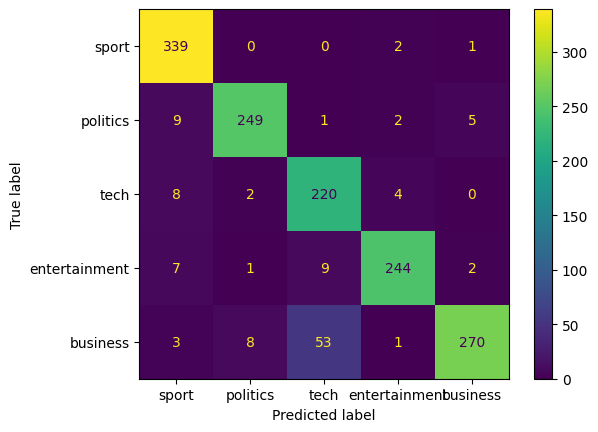

Accuracy: 0.9180555555555555


In [34]:
conf_matrix = confusion_matrix(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred)
# Need to sort labels by dictionary value to match new indexes given to categories.
# This is done in display_labels. A little convoluted but works for now.
ConfusionMatrixDisplay(conf_matrix, display_labels = {k: v for k, v in sorted(labels.items(), key = lambda item: item[1])}).plot()
plt.show()

print('Accuracy:', accuracy_score(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred))

For a only a few test fits 91.8% is pretty good accuracy. It still seems to have trouble classifying most categories, but especially business incorrectly being classified as a tech article.

Now, it is time to optimize not only the NMF model, but also TF-IDF. 

*Note: This is a time intensive process so the results will be saved into a .csv file so this code block can be commented out for future runs.*

In [35]:
def model_optimizer_nmf(param_grid, train_df, k_folds = 3):
    '''
    Takes a parameter grid to optimize TF-IDF and NMF through K-Fold cross validation.
    This results in permutations(parameters) * k_folds models being fit.
    Parameters:
        param_grid: Dictionary of parameters in the form: {'Name':[Value]}
        train_df: Dataframe of training data.
    Returns:
        opt_params: Dictionary of parameters with highest mean accuracy during validation.
        opt_label_order: Label order of highest accuracy permutation.
        opt_acc: Highest mean validation accuracy.
        opt_df: Dataframe of all results.
    '''
    # Find all parameter permutations
    params_permut = list(itertools.product(*param_grid.values()))  
    print(f'The number of parameter combinations to be tested: {len(params_permut)}')
    print(f'The number of models tested with cross-validation: {len(params_permut) * k_folds}')

    # Initialize optimized variables.
    opt_array = np.full((len(params_permut) * k_folds, len(param_grid) + 4), fill_value = np.nan, dtype = 'O')
    opt_acc = float('-inf')
    opt_label_order = None
    opt_params = None

    # A K-Fold method will be used to split the training set into training and validation sets.
    cross_val = KFold(n_splits = k_folds, shuffle = True)

    # Loop through each parameter permutation.
    for i, par in enumerate(params_permut):
        current_params = dict(zip(param_grid.keys(), par))
        if i % 100 == 0:
            print('Current Combo:', i+1, '| Params:', current_params)
        # Handle some incompatible combinations of parameters.
        if (current_params['solver'] == 'cd') and (current_params['beta_loss'] == 'kullback-leibler'):
            continue # Skip loop
        if (current_params['solver'] == 'mu') and (current_params['init'] == 'nndsvd'):
            continue # Skip loop
        
        # Holds each fold's accuracy to be averaged after.
        fold_accuracy = []

        for train_index, val_index in cross_val.split(train_df):
            train_fold = train_df.iloc[train_index].copy()
            val_fold = train_df.iloc[val_index].copy()

            # TF-IDF
            tfidf, X_train_sparse_nmf = tf_vectorize(train_fold['cleaned'], current_params)
            X_val_sparse_nmf = tfidf.transform(val_fold['cleaned'])

            # NMF
            mod_nmf = NMF(n_components = 5, 
                        init = current_params['init'], 
                        solver = current_params['solver'], 
                        beta_loss = current_params['beta_loss'],
                        tol = 0.000001,
                        max_iter = 500,
                        random_state = 11,
                        l1_ratio = current_params['l1_ratio'],
                        verbose = 0)

            mod_nmf_train = mod_nmf.fit_transform(X_train_sparse_nmf)
            mod_nmf_val = mod_nmf.transform(X_val_sparse_nmf)
            mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1)
            mod_nmf_val_y_pred = mod_nmf_val.argmax(axis = 1)
            
            label_order, acc = label_permute_accuracy(val_fold, mod_nmf_val_y_pred)
            fold_accuracy.append(acc)

        # Average and calculate results.
        avg_acc = np.mean(fold_accuracy)
        model_results = list(par) + fold_accuracy + [avg_acc]
        opt_array[i] = model_results
        #print(f'Average accuracy for params {current_params}: {avg_acc}')
        
        if avg_acc > opt_acc:
            opt_acc = avg_acc
            opt_label_order = label_order
            opt_params = current_params
            print('   Accuracy Increased!!!', opt_acc, 'Current Combo:', i+1, '| Params:', current_params)

    print(f'Optimized Model:\n  Parameters - {opt_params}\n  Label Order - {opt_label_order}\n  Cross-Val Accuracy - {opt_acc}')
    # Save results to csv.
    column_names = list(param_grid.keys()) + ['val_acc_1','val_acc_2','val_acc_3','val_acc_avg']
    opt_df = pd.DataFrame(opt_array, columns = column_names)
    opt_df.to_csv(current_wdir + f'/Models/NMF/Optimization_Results.csv.gz', compression = 'gzip', index = False)

    return (opt_params, opt_label_order, opt_acc, opt_df)

In [36]:
# Comment out after running. Results are saved in function call and can be loaded in next code block.
# Optimization Grid
# param_grid = {'min_df' : [1,2,3,10],
#               'max_df' : np.linspace(0.2,0.8,4),
#               'norm' : ['l1','l2'],
#               'ngram_range' : [(1,1),(1,2),(1,3)],
#               'init' : ['nndsvd','nndsvda'],
#               'solver' : ['cd','mu'],
#               'beta_loss' : ['frobenius','kullback-leibler'],
#               'l1_ratio' : np.linspace(0,1,5)}

# opt_params, opt_label_order, opt_acc, opt_df = model_optimizer_nmf(param_grid = param_grid, train_df = train, k_folds = 3)

The number of parameter combinations to be tested: 3840
The number of models tested with cross-validation: 11520
Current Combo: 1 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9083333333333333 Current Combo: 1 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9249999999999999 Current Combo: 2 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.25}
   Accuracy Increased!!! 0.9270833333333334 Current Combo: 5 | Params: {'min_df': 1, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 1.0}
   Accuracy Increased!!! 0.9298611111111111 Current Combo: 31 | Params: {'

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


   Accuracy Increased!!! 0.9534722222222222 Current Combo: 398 | Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.5}
Current Combo: 401 | Params: {'min_df': 1, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 501 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 601 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9541666666666666 Current Combo: 640 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1.0}
Current Combo: 701 | Params: {'min_df': 1, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 3), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 801 | Params: {'min_df': 1, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 901 | Params: {'min_df': 1, 'max_df': 0.8, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 1001 | Params: {'min_df': 2, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9576388888888889 Current Combo: 1036 | Params: {'min_df': 2, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.0}
   Accuracy Increased!!! 0.9597222222222223 Current Combo: 1037 | Params: {'min_df': 2, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.25}
   Accuracy Increased!!! 0.9618

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 2001 | Params: {'min_df': 3, 'max_df': 0.2, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2101 | Params: {'min_df': 3, 'max_df': 0.2, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2201 | Params: {'min_df': 3, 'max_df': 0.4, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}


/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 2301 | Params: {'min_df': 3, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2401 | Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2501 | Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2601 | Params: {'min_df': 3, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2701 | Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 2801 | Params: {'min_df': 3, 'max_df': 0.8, 'norm': 'l2', 'ngram_range':

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Current Combo: 3201 | Params: {'min_df': 10, 'max_df': 0.4, 'norm': 'l1', 'ngram_range': (1, 3), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3301 | Params: {'min_df': 10, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 2), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3401 | Params: {'min_df': 10, 'max_df': 0.6000000000000001, 'norm': 'l1', 'ngram_range': (1, 2), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3501 | Params: {'min_df': 10, 'max_df': 0.6000000000000001, 'norm': 'l2', 'ngram_range': (1, 1), 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3601 | Params: {'min_df': 10, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 1), 'init': 'nndsvd', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.0}
Current Combo: 3701 | Params: {'min_df': 10, 'max_df': 0.8, 'norm': 'l1', 'ngram_range': (1, 3), '

In [37]:
# Load and read in previously saved optimizations.
file = current_wdir + f'/Models/NMF/Optimization_Results.csv.gz'
opt_df = pd.read_csv(file, compression = 'gzip')
opt_df = opt_df.dropna()
# min_df should be an int otherwise means proportion as float.
opt_df.min_df = opt_df.min_df.astype(int)
# Find best cross-val score and cast parameters to dictionary.
opt_params = opt_df.sort_values(by = 'val_acc_avg', ascending=False).iloc[1,:8].to_dict()
# This is ugly but converting string to tuple.
convert_tuple = opt_params['ngram_range']
convert_tuple = tuple(map(int, convert_tuple.strip('()').split(',')))
opt_params['ngram_range'] = convert_tuple
opt_params

{'min_df': 3,
 'max_df': 0.4,
 'norm': 'l2',
 'ngram_range': (1, 3),
 'init': 'nndsvda',
 'solver': 'mu',
 'beta_loss': 'kullback-leibler',
 'l1_ratio': 0.25}

Now to refit NMF with optimized parameters.

*Note: The optimized TF-IDF parameters will remain the same for the rest of this project.*

In [38]:
def nmf_fit_optimized(X_train, verbose = False):

    tfidf, X_train_sparse_nmf = tf_vectorize(X_train, opt_params)

    mod_nmf = NMF(n_components = 5, 
                init = opt_params['init'], 
                solver = opt_params['solver'], 
                beta_loss = opt_params['beta_loss'],
                tol = 0.000001,
                max_iter = 500,
                random_state = 11,
                l1_ratio = opt_params['l1_ratio'],
                verbose = 0)
    mod_nmf_train = mod_nmf.fit_transform(X_train_sparse_nmf)
    mod_nmf_train_y_pred = mod_nmf_train.argmax(axis = 1)

    if verbose == True:
        print(f'Modeling using optimized parameters:\n {opt_params}')
        print(X_train_sparse_nmf.shape, '- Articles X Tokens | Sparse Matrix Shape')
        print(mod_nmf_train.shape, '- Articles X Topics | NMF Weights Matrix Shape')
        print(mod_nmf.components_.shape, '- Topics X Tokens | NMF Components Matrix Shape')

    return (tfidf, X_train_sparse_nmf, mod_nmf, mod_nmf_train_y_pred)

In [39]:
tfidf, train_sparse_embed_nmf, mod_nmf, mod_nmf_train_y_pred = nmf_fit_optimized(train['cleaned'], verbose = True)
label_order, acc = label_permute_accuracy(train, mod_nmf_train_y_pred)

# Map best accuracy permutation order and predictions to dataframe.
labels = {key : i for i, key in zip(label_order, train['Category'].unique())}
train['class_perm'] = train['Category'].map(labels)

Modeling using optimized parameters:
 {'min_df': 3, 'max_df': 0.4, 'norm': 'l2', 'ngram_range': (1, 3), 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.25}
(1440, 22830) - Articles X Tokens | Sparse Matrix Shape
(1440, 5) - Articles X Topics | NMF Weights Matrix Shape
(5, 22830) - Topics X Tokens | NMF Components Matrix Shape


Confusion Matrix on training set.

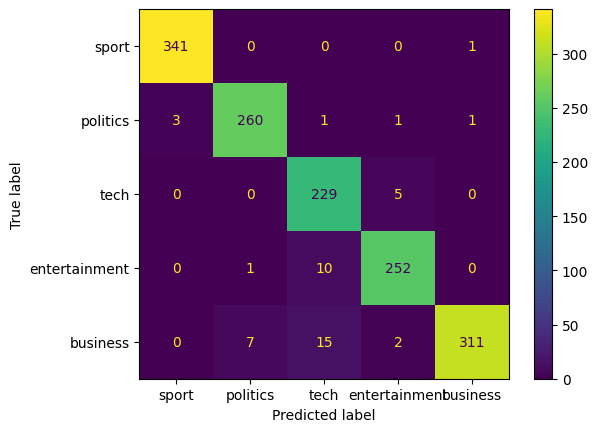

Accuracy: 0.9673611111111111


In [40]:
conf_matrix = confusion_matrix(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = {k: v for k, v in sorted(labels.items(), key = lambda item: item[1])}).plot()
plt.show()

print('Accuracy:', accuracy_score(y_true = train['class_perm'], y_pred = mod_nmf_train_y_pred))

Here we will predict on the Test set. Results can be found in the conclusion section.

In [41]:
X_test_sparse_nmf = tfidf.transform(X_test['cleaned'])
mod_nmf_X_test = mod_nmf.transform(X_test_sparse_nmf)
y_pred_nmf = mod_nmf_X_test.argmax(axis = 1)

# Map best accuracy permutation order and predictions to dataframe.
labels_test = {key : i for i, key in zip(train['Category'].unique(), label_order)}
X_test['y_pred'] = y_pred_nmf
X_test['Category'] = X_test['y_pred'].map(labels_test)

# Output test results for kaggle submission scoring.
X_test[['ArticleId', 'Category']].to_csv(current_wdir + f'/Models/NMF/X_test_Submission_NMF.csv', index = False)

This is a good time to take a more detailed look at the optimization results to which parameters were the most relevant with NMF and this dataset.

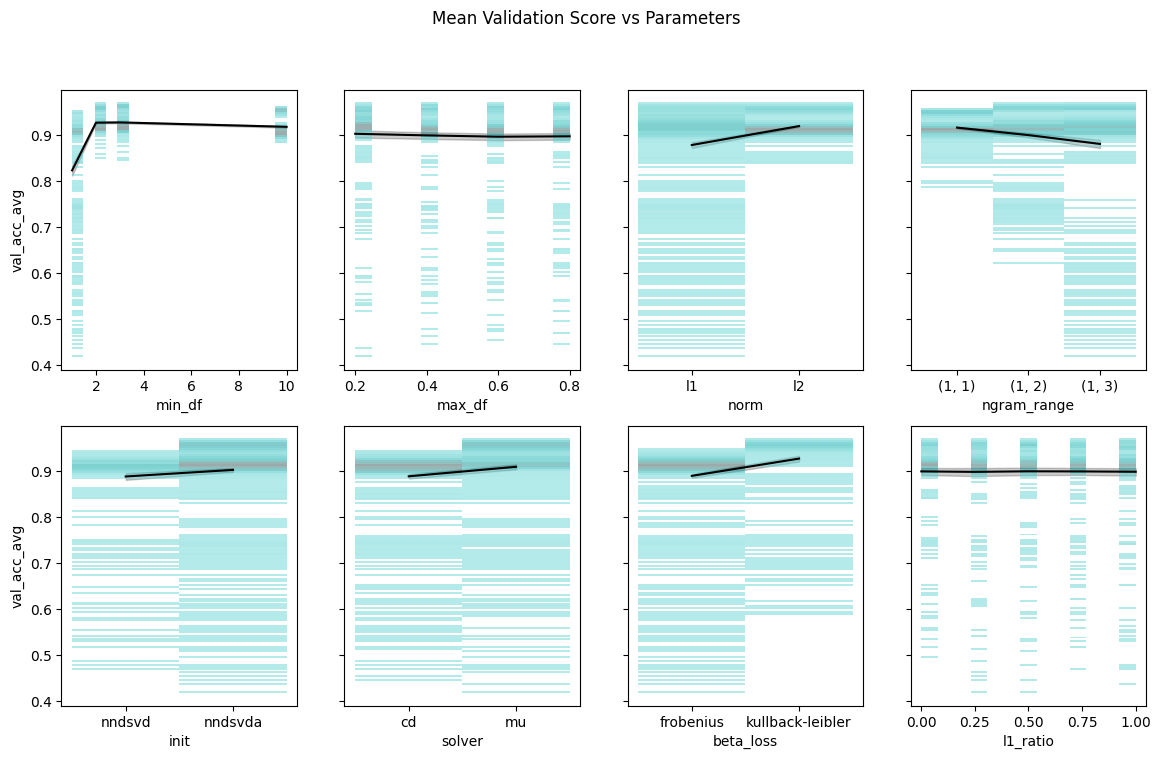

In [42]:
fig, ax = plt.subplots(2, int(len(opt_params) / 2), figsize = (14, 8), sharey = True)

for i, col in enumerate(opt_params.keys()):
    sns.lineplot(data = opt_df, ax = ax[i//4, i%4], x = col, y = 'val_acc_avg', estimator = 'mean', color = 'black')
    sns.histplot(data = opt_df, ax = ax[i//4, i%4], x = col, y = 'val_acc_avg', color = 'teal', alpha = 0.5)
fig.suptitle('Mean Validation Score vs Parameters')
plt.show()

This plot is admittedly limited in it use because it doesn't show how each parameter works in combination with changes in the others. 

That being said, it does gives a decent view of how each singular parameter change might affect accuracy and what the distribution of scores looks like with that selected parameter.

Notable observations:
- `ngram_range` the distribution of accuracy scores widens as you add bigrams and trigrams, requiring more tuning, but with that tuning gains a little in accuracy. This fact wouldn't be noticeable when solely looking at the averaged line plot.
- `init`, `solver`, `beta-loss` all show one of their parameters (each on the right on this plot) performing better than the other. We would expect to see the best performing models to all use `nndsvda`, `mu`, and `kullback-leibler` respectively.
- `max_df` surprisingly shows fairly even distributions across parameter changes. Intuition during initial fit is that this is an important parameter because it removes words that all articles share at different proportion thresholds, which essentially removes noise. The even distribution of accuracy scores indicates to me that this parameter, while important, also heavily relies on other parameter's tuning, or more values near the end range should be tested (0.05-0.2 and/or 0.8-0.95).
- `min_df` shows a very clear picture, gaining accuracy score at the value of 3. It exhibits a slight slope downward towards 10, which still shows decent accuracy score. Exploring more values above 10 may be useful in the future.

Now let's sort the optimization results dataframe by average validation accuracy to see if these observations hold true.

In [43]:
opt_df.sort_values(by = 'val_acc_avg', ascending = False).head(15)

,min_df,max_df,norm,ngram_range,init,solver,beta_loss,l1_ratio,val_acc_1,val_acc_2,val_acc_3,val_acc_avg
1558,2,0.6,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.75,0.970833,0.968750,0.975000,0.971528
2396,3,0.4,l2,"(1, 3)",nndsvda,mu,kullback-leibler,0.25,0.968750,0.964583,0.975000,0.969444
2477,3,0.6,l1,"(1, 2)",nndsvda,mu,kullback-leibler,0.50,0.966667,0.977083,0.964583,0.969444
1795,2,0.8,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.00,0.966667,0.968750,0.968750,0.968056
2399,3,0.4,l2,"(1, 3)",nndsvda,mu,kullback-leibler,1.00,0.966667,0.960417,0.975000,0.967361
2118,3,0.2,l2,"(1, 2)",nndsvda,mu,kullback-leibler,0.75,0.966667,0.970833,0.964583,0.967361
1199,2,0.2,l2,"(1, 3)",nndsvda,mu,kullback-leibler,1.00,0.966667,0.977083,0.958333,0.967361
2038,3,0.2,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.75,0.966667,0.954167,0.979167,0.966667
2397,3,0.4,l2,"(1, 3)",nndsvda,mu,kullback-leibler,0.50,0.964583,0.962500,0.972917,0.966667
2515,3,0.6,l1,"(1, 3)",nndsvda,mu,kullback-leibler,0.00,0.956250,0.964583,0.979167,0.966667


This looks almost exactly as expected from the plot. 

There also appears to be a tie for the best model parameters with differences in `max_df`, `norm`, `ngram_range`. The code uses greater than to find the optimized results so the first encountered combination was what has been used. In this case the model in the 2nd row. It would be worth seeing how the other model performs as well since it includes trigrams and uses l2 normalization.

###### [Back to Table of Contents](#toc)

### 5.4. Supervised Models <a name="super"></a>

#### 5.4.1. XGBoost <a name="xgb"></a>

XGBoost is a strong supervised model that generalizes well with a wide variety of data amounts and types. It utilizes gradient boosting to create decision trees in a sequential process, this makes it less efficient than random forest, but typically outperforms most other decision trees, and is generally more scalable than other boosting techniques.

*Note: Same as with the NMF optimization process, the following function will save the results and can be reloaded later if the notebook needs to be rerun without optimizing again.*

In [44]:
def model_optimizer_xgb(param_grid_xgb, train_df, k_folds = 3):
    params_permut = list(itertools.product(*param_grid_xgb.values()))  
    print(f'The number of parameter combinations to be tested: {len(params_permut)}')
    print(f'The number of models tested with cross-validation: {len(params_permut) * k_folds}')

    opt_array = np.full((len(params_permut) * k_folds, len(param_grid_xgb) + 4), fill_value = np.nan, dtype = 'O')
    opt_log_loss = float('inf')
    opt_params_xgb = None

    cross_val = KFold(n_splits = k_folds, shuffle = True)

    for i, par in enumerate(params_permut):
        current_params = dict(zip(param_grid_xgb.keys(), par))
        if i % 10 == 0:
            print('Current Combo:', i+1, '| Params:', current_params)

        fold_log_loss = []

        for train_index, val_index in cross_val.split(train_df):
            train_fold = train_df.iloc[train_index].copy()
            val_fold = train_df.iloc[val_index].copy()
            
            #TF-IDF
            tfidf, X_train_sparse_xgb = tf_vectorize(train_fold['cleaned'], opt_params)
            X_val_sparse_xgb = tfidf.transform(val_fold['cleaned'])
            
            #XGBoost
            mod_xgb = xgb.XGBClassifier(booster = 'gbtree',
                                n_estimators = 6000,
                                max_depth = current_params['max_depth'],
                                learning_rate = current_params['learning_rate'],
                                gamma = current_params['gamma'],
                                early_stopping_rounds = 100,
                                num_class = 5,
                                objective = 'multi:softmax')

            mod_xgb.fit(X_train_sparse_xgb, train_fold['class_perm'],
                        eval_set = [(X_val_sparse_xgb, val_fold['class_perm'])],
                        verbose = False)

            fold_log_loss.append(mod_xgb.best_score)

        avg_log_loss = np.mean(fold_log_loss)
        model_results = list(par) + fold_log_loss + [avg_log_loss]
        opt_array[i] = model_results
        #print(f'Average loss for params {current_params}: {avg_log_loss}')
        
        if avg_log_loss < opt_log_loss:
            opt_log_loss = avg_log_loss
            opt_params_xgb = current_params
            print('   Loss Decreased!!!', opt_log_loss, 'Current Combo:', i+1, '| Params:', current_params)

    print(f'Optimized Model:\n  Parameters - {opt_params_xgb}\n  Cross-Val Log Loss - {opt_log_loss}')
    # Save results to csv.
    column_names = list(param_grid_xgb.keys()) + ['val_loss_1','val_loss_2','val_loss_3','val_loss_avg']
    opt_df = pd.DataFrame(opt_array, columns = column_names)
    opt_df.to_csv(current_wdir + f'/Models/XGB/Optimization_Results.csv.gz', compression = 'gzip', index = False)

    return (opt_params_xgb, opt_log_loss, opt_df)

In [46]:
# Comment out after running.
# Optimization Grid
# param_grid_xgb = {'max_depth' : [None,1,3,5],
#               'learning_rate' : [0.1,0.05,0.01],
#               'gamma' : [0.05,0.1,0.5]}
# opt_params_xgb, opt_log_loss_xgb, opt_df_xgb = model_optimizer_xgb(param_grid_xgb = param_grid_xgb, train_df = train, k_folds = 3)

The number of parameter combinations to be tested: 36
The number of models tested with cross-validation: 108
Current Combo: 1 | Params: {'max_depth': None, 'learning_rate': 0.1, 'gamma': 0.05}
   Loss Decreased!!! 0.21146580136014057 Current Combo: 1 | Params: {'max_depth': None, 'learning_rate': 0.1, 'gamma': 0.05}
   Loss Decreased!!! 0.20589813640237684 Current Combo: 2 | Params: {'max_depth': None, 'learning_rate': 0.1, 'gamma': 0.1}
   Loss Decreased!!! 0.1943852439158137 Current Combo: 4 | Params: {'max_depth': None, 'learning_rate': 0.05, 'gamma': 0.05}
Current Combo: 11 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.1}
   Loss Decreased!!! 0.1751299010905607 Current Combo: 13 | Params: {'max_depth': 1, 'learning_rate': 0.05, 'gamma': 0.05}
Current Combo: 21 | Params: {'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.5}
Current Combo: 31 | Params: {'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.05}
Optimized Model:
  Parameters - {'max_depth': 1, 'learning_rate':

In [47]:
# Load and read in previously saved optimizations.
file = current_wdir + f'/Models/XGB/Optimization_Results.csv.gz'
opt_df_xgb = pd.read_csv(file, compression = 'gzip')
# Find best cross-val score and cast parameters to dictionary.
opt_params_xgb = opt_df_xgb.sort_values(by = 'val_loss_avg', ascending=True).iloc[1,:3].to_dict()
opt_params_xgb['max_depth'] = int(opt_params_xgb['max_depth'])
opt_params_xgb

{'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.05}

Now to fit with optimized parameters and submit the predictions on the test set.

In [48]:
def xgb_fit_optimized(X_train, y_train, verbose = False):

    if verbose == True:
        print(f'Modeling using optimized parameters:\n {opt_params_xgb}')

    tfidf, X_train_sparse_xgb = tf_vectorize(X_train, opt_params)

    mod_xgb = xgb.XGBClassifier(booster = 'gbtree',
                                    n_estimators = 6000,
                                    max_depth = opt_params_xgb['max_depth'],
                                    learning_rate = opt_params_xgb['learning_rate'],
                                    gamma = opt_params_xgb['gamma'],
                                    early_stopping_rounds = 100,
                                    num_class = 5,
                                    objective = 'multi:softmax')

    mod_xgb.fit(X_train_sparse_xgb, y_train,
                eval_set = [(X_train_sparse_xgb, y_train)],
                verbose = False)
    
    return (tfidf, X_train_sparse_xgb, mod_xgb)

In [49]:
tfidf, train_sparse_embed_xgb, mod_xgb = xgb_fit_optimized(train['cleaned'], train['class_perm'], verbose = True)

Modeling using optimized parameters:
 {'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.05}


Confusion Matrix on training set.

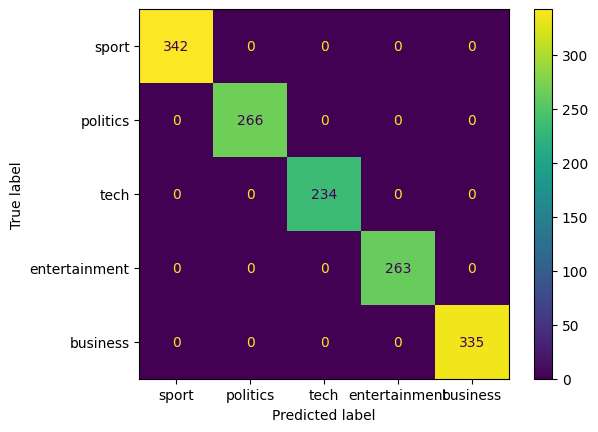

Accuracy: 1.0


In [50]:
conf_matrix = confusion_matrix(y_true = train['class_perm'], y_pred = mod_xgb.predict(train_sparse_embed_xgb))
ConfusionMatrixDisplay(conf_matrix, display_labels = {k: v for k, v in sorted(labels.items(), key = lambda item: item[1])}).plot()
plt.show()

print('Accuracy:', accuracy_score(y_true = train['class_perm'], y_pred = mod_xgb.predict(train_sparse_embed_xgb)))

Here we will predict on the Test set. Results can be found in the conclusion section.

In [51]:
X_test_sparse_embed = tfidf.transform(X_test['cleaned'])
y_pred_xgb = mod_xgb.predict(X_test_sparse_embed)

X_test['y_pred_xgb'] = y_pred_xgb
X_test['Category'] = X_test['y_pred_xgb'].map(labels_test)
# Output test results for kaggle submission scoring.
X_test[['ArticleId', 'Category']].to_csv(current_wdir + f'/Models/XGB/X_test_Submission_XGB.csv', index = False)

##### 5.4.1.1. Feature Importance <a name="featimp"></a>

XGBoost has the useful property of being able to calculate feature importance. If we can extra those scores and inversely transform our TF-IDF vocabulary, we can map those features to words.

In [52]:
# Extract feature importance from XGB object.
feat_imp = mod_xgb.get_booster().get_score(importance_type = 'gain')
feat_imp_df = pd.DataFrame(data = feat_imp.values(), index = feat_imp.keys(), columns = ['Gain'])
# Remove f from index so we can index tfidf features.
feat_imp_df.index = feat_imp_df.index.str.strip('f')
# Extract feature mapping from tfidf.
tfidf_feature_map = tfidf.get_feature_names_out()
# Take index from XGB and index tfidf features.
feat_imp_df['Word'] = tfidf_feature_map[feat_imp_df.index.astype(int)]
feat_imp_df = feat_imp_df.sort_values(by = 'Gain', ascending = False)
feat_imp_df.iloc[0:25]

,Gain,Word
20437,36.082397,tony blair
21375,31.069733,users
18213,25.025095,shares
7601,23.278578,film
10961,23.030931,labour
4192,21.173267,coach
13899,19.122845,oil
9074,14.643238,growth
22102,13.030367,win
18462,12.721332,singer


Now to show an approximation of how the decision trees were built, we can plot the results and attempt to show which category these words belong to and how nodes on the trees were split.

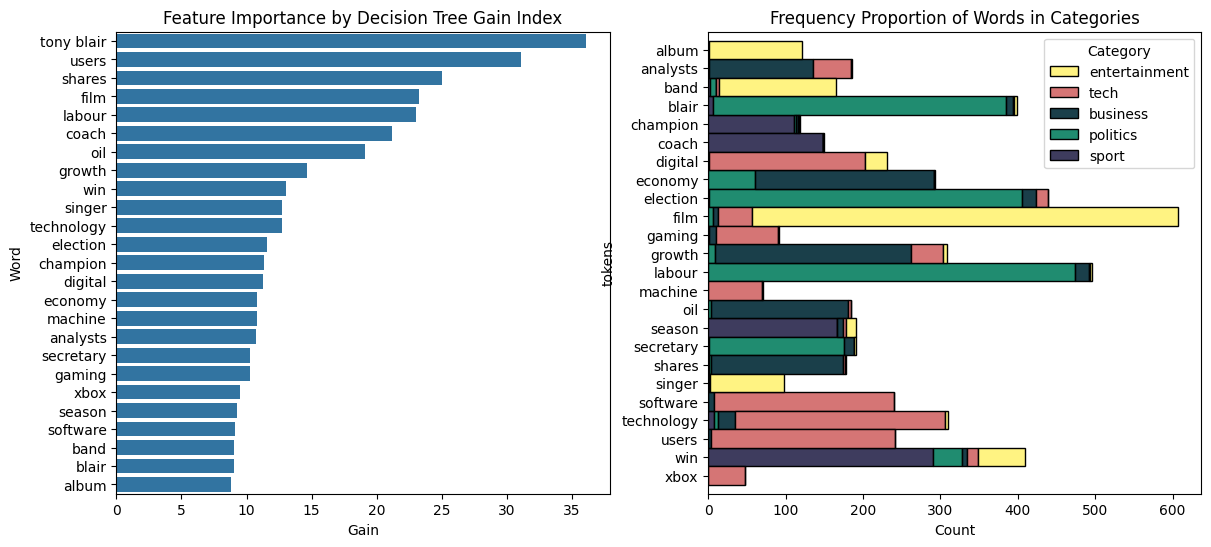

In [53]:
fig, ax = plt.subplots(1,2, figsize = (14, 6))

sns.barplot(feat_imp_df.nlargest(25, columns = 'Gain'), x = 'Gain', y = 'Word', ax = ax[0])
ax[0].set_title('Feature Importance by Decision Tree Gain Index')
feat_imp_stacked = token_cat_freq[token_cat_freq['tokens'].isin(feat_imp_df['Word'].iloc[0:25])].groupby(["tokens","Category"]).sum()
feat_imp_stacked

sns.histplot(feat_imp_stacked, y = 'tokens', weights = 'frequency', multiple = 'stack', hue = 'Category', ax = ax[1], palette = category_cmap, alpha = 0.9)
ax[1].set_title('Frequency Proportion of Words in Categories')
plt.margins(y = 0.02)
plt.yticks(rotation = 0)
plt.show()

As can be seen from these two plots, most of the words with the highest gain index have fairly pure category proportions.

*Note: Wasn't able to include the bigrams in this implementation because of the finnicky nature of plotting stacked barcharts. For convenience I have left the stacked bar chart in alphabetical order so the viewer can easily find relevant terms from the left plot on the right plot.*

###### [Back to Table of Contents](#toc)

#### 5.4.2. Support Vector Machine (SVM) <a name="svm"></a>

A Support Vector Machine will be fit to the TF-IDF sparse matrix -- to give a clearer picture for the following supervised and unsupervised model comparisons.

In [54]:
# We'll use sklearn's grid search for optimizing this time.
# Comment out to save rerun time, though only takes about 7 minutes.

params = {'C' : [0.01,1,5,8,9,10,11,12,14,15], 
          'gamma' : [0.01,1,5,8,9,10,11,12,13], 
          'kernel' : ['rbf']}

tfidf, X_train_sparse_svm = tf_vectorize(train['cleaned'], opt_params)

grid_svm = GridSearchCV(SVC(), param_grid = params, cv = 3, verbose = 0).fit(X_train_sparse_svm, train['class_perm'])

mod_svm = grid_svm.best_estimator_
opt_params_svm = grid_svm.best_params_

print(mod_svm)
print(mod_svm.score(X_train_sparse_svm, train['class_perm']))

SVC(C=5, gamma=1)
1.0


In [55]:
def svm_fit_optimized(X_train, y_train, verbose = False):

    # TF-IDF
    tfidf, X_train_sparse_svm = tf_vectorize(X_train, opt_params)

    # SVM
    mod_svm = SVC(C = opt_params_svm['C'], 
                  gamma = opt_params_svm['gamma'], 
                  kernel = opt_params_svm['kernel'])
    mod_svm.fit(X_train_sparse_svm, y_train)

    if verbose == True:
        print(f'Modeling using optimized parameters:\n {opt_params_svm}')
        print('Training Set Accuracy:', mod_svm.score(X_train_sparse_svm, y_train))

    return (tfidf, X_train_sparse_svm, mod_svm)

In [56]:
tfidf, train_sparse_embed_svm, mod_svm = svm_fit_optimized(train['cleaned'], train['class_perm'], verbose = True)

Modeling using optimized parameters:
 {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
Training Set Accuracy: 1.0


Here we will predict on the Test set. Results can be found in the conclusion section.

In [57]:
X_test_sparse_embed = tfidf.transform(X_test['cleaned'])
y_pred_svm = mod_svm.predict(X_test_sparse_embed)
X_test['y_pred_svm'] = y_pred_svm
X_test['Category'] = X_test['y_pred_svm'].map(labels_test)
# Output test results for kaggle submission scoring.
X_test[['ArticleId', 'Category']].to_csv(current_wdir + f'/Models/SVM/X_test_Submission_SVM.csv', index = False)

###### [Back to Table of Contents](#toc)

## 6. Comparison of Supervised / Unsupervised at Different Training Data Sizes <a name="comparison"></a>

---

Before moving on to evaluating the test set results, each model's performance will be fitted and evaluated on different proportions of training data.

This will be accomplished by:
1. Randomly sample indexes (without replacement) from the training data for a range of proportion sizes: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9].
2. Fit each model to these random training subsets.
3. Use the remaining unsampled training data as the test set to predict y and evaluate accuracy.
4. Resample the training data 4 more times (5 times total for each proportion size) and record an accuracy score for each model and split.
5. Average the 5 accuracy scores of the 5 resamples as the final evaluation for that proportion size.

In [58]:
train_sizes = np.round(np.linspace(0.1,0.9,9), 2) # Rounding to avoid float errors.
n_resamples = 5
scores = {'NMF' : {'train' : {},
                   'test' : {}},
          'XGB' : {'train' : {},
                   'test' : {}},
          'SVM' : {'train' : {},
                   'test' : {}}}
print(f'Randomly resampling Training/Testing splits using a range of train proportions; Resampled {n_resamples} times each, then averaging results.')
for train_size in train_sizes:
    # Convert train proportion to percentage for labels.
    train_size_str = str(train_size*100)+'%'
    # Initialize train size in scores dictionary.
    scores['NMF']['train'][train_size_str], scores['NMF']['test'][train_size_str] = [], []
    scores['XGB']['train'][train_size_str], scores['XGB']['test'][train_size_str] = [], []
    scores['SVM']['train'][train_size_str], scores['SVM']['test'][train_size_str] = [], []
    print(f'Current Train Split Proportion: {train_size}')
    for i in range(n_resamples):
        X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(train, train['class_perm'],
                                                                                    train_size = train_size,
                                                                                    shuffle = True)
        # NMF
        # Train
        tfidf, train_sparse_embed_nmf, mod_nmf, mod_nmf_train_y_pred = nmf_fit_optimized(X_train_sampled['cleaned'], verbose = False)
        # Train Accuracy
        label_order, acc = label_permute_accuracy(X_train_sampled, mod_nmf_train_y_pred)
        scores['NMF']['train'][train_size_str].append(acc)
        # Test
        X_test_sparse_embed = tfidf.transform(X_test_sampled['cleaned'])
        mod_nmf_X_test = mod_nmf.transform(X_test_sparse_embed)
        y_pred_nmf = mod_nmf_X_test.argmax(axis = 1)
        # Test Accuracy
        label_order, acc = label_permute_accuracy(X_test_sampled, y_pred_nmf)
        scores['NMF']['test'][train_size_str].append(acc)

        # XGBoost
        # Train
        tfidf, train_sparse_embed_xgb, mod_xgb = xgb_fit_optimized(X_train_sampled['cleaned'], y_train_sampled, verbose = False)
        # Train Accuracy
        acc = accuracy_score(y_train_sampled, mod_xgb.predict(train_sparse_embed_xgb))
        scores['XGB']['train'][train_size_str].append(acc)
        # Test
        X_test_sparse_embed = tfidf.transform(X_test_sampled['cleaned'])
        y_pred_xgb = mod_xgb.predict(X_test_sparse_embed)
        # Test Accuracy
        acc = accuracy_score(y_test_sampled, y_pred_xgb)
        scores['XGB']['test'][train_size_str].append(acc)

        # SVM
        # Train
        tfidf, train_sparse_embed_svm, mod_svm = svm_fit_optimized(X_train_sampled['cleaned'], y_train_sampled, verbose = False)
        # Train Accuracy
        acc = accuracy_score(y_train_sampled, mod_svm.predict(train_sparse_embed_svm))
        scores['SVM']['train'][train_size_str].append(acc)
        # Test
        X_test_sparse_embed = tfidf.transform(X_test_sampled['cleaned'])
        y_pred_svm = mod_svm.predict(X_test_sparse_embed)
        # Test Accuracy
        acc = accuracy_score(y_test_sampled, y_pred_svm)
        scores['SVM']['test'][train_size_str].append(acc)

Randomly resampling Training/Testing splits using a range of train proportions; Resampled 5 times each, then averaging results.
Current Train Split Proportion: 0.1
Current Train Split Proportion: 0.2
Current Train Split Proportion: 0.3
Current Train Split Proportion: 0.4
Current Train Split Proportion: 0.5
Current Train Split Proportion: 0.6
Current Train Split Proportion: 0.7
Current Train Split Proportion: 0.8
Current Train Split Proportion: 0.9


In [59]:
print('Training Sizes - # of Articles')
print(list(train_sizes * len(train)))

Training Sizes - # of Articles
[144.0, 288.0, 432.0, 576.0, 720.0, 864.0, 1007.9999999999999, 1152.0, 1296.0]


In [60]:
comparison_df = pd.DataFrame()

# Unpack nested dictionary to create dataframe of scores.
for model in scores:
    for split in scores[model]:
        proportions = scores[model][split].keys()
        values = scores[model][split].values()
        means = [np.mean(val) for val in values]

        df_index = pd.MultiIndex.from_product([[model], [split]], names = ['Model', 'Split'])
        comparison_df = pd.concat([comparison_df, pd.DataFrame([means], columns = proportions, index = df_index)])

In [88]:

# Highlight the best model's test results green at each proportion.
def max_value_highlight(df, train = True):
    # Hard coding the test rows because creating a boolean mask
    # that works with the styler and conditioning on multiindex is a nightmare.
    if train == False: # Don't omit rows.
        max_test_rows = df.max()
    else:
        max_test_rows = df.iloc[[1,3,5]].max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df, train = True):
    # Sort values
    if train == False: # Don't omit rows.
        test_rows = df
    else:
        test_rows = df.iloc[[1,3,5]]
    sorted_df = test_rows.sort_values(ascending = False)
    top_two = sorted_df.iloc[: 2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

In [91]:
# Apply highlight_top_two() first so max_value_highlight() overlaps.
# Leaving only 2nd place as blue and 1st in green.
comparison_df.style.apply(highlight_top_two).apply(max_value_highlight)

- The best performing model at each dataset size is highlighted in green.
- the 2nd best is highlighted in blue.

---

The SVM outperformed both NMF and XGB at most dataset sizes. Exceptions occurred when trained with 50% of the data, where both SVM and NMF achieved identical mean accuracy scores, and at 10%, where the NMF model achieved a score of roughly 92%, exceeding the SVM result of 87.3%. At this smaller training size, the SVM performance began to decline. Despite this, both SVM and NMF performed exceedingly well across all training set sizes. While the SVM proved effective at topic classification with this dataset and smaller amounts of training data, it struggles with larger dataset sizes and feature spaces, which are common in natural language processing.

NMF performed almost as well as SVM throughout the tests, often only a tenth of a percent below. This demonstrates the effectiveness of unsupervised learning, as it specializes in learning latent features without the need for class labels, a common scenario in real production, and it does so efficiently with sparse data.

XGB performed well, but its performance plateaued and even dropped at 40% and 10% training set sizes. These results highlight a common issue with decision trees: overfitting. This model type is prone to overfitting even with careful tuning. Additionally, decision trees generally struggle with extrapolating information that wasn't presented in their training data, a problem that becomes more prevalent as training data sizes decrease or data drift occurs in unseen data.

###### [Back to Table of Contents](#toc)

## 7. Conclusion - Kaggle Test Set <a name="conclusion"></a>

---

To evaluate the test set the .csv files must be submitted to Kaggle in the `sample_y_test` format. Each model's predictions were saved for submission and a screenshot of the results is below.

<img src="https://github.com/chill0121/News_Article_Matrix_Factorization/blob/main/Models/Kaggle_Results.png?raw=true" alt="results" width="1000"/>

For continuity sake, let's put this in a dataframe along with our baseline models for easier comparison, and highlight in the same manner as before.

In [90]:
results_test = {'Random_Baseline' : mod_rand_baseline,
                'Frequent_Baseline' : mod_freq_baseline,
                'NMF' : 0.97006,
                'XGB' : 0.95646,
                'SVM' : 0.98231}

results_test_df = pd.DataFrame().from_dict(results_test, orient = 'index', columns = ['Accuracy'])
results_test_df.index.name = 'Model'

results_test_df.style.apply(highlight_top_two, train = False).apply(max_value_highlight, train = False)

,Accuracy
Model,
Random_Baseline,0.200000
Frequent_Baseline,0.224480
NMF,0.970060
XGB,0.956460
SVM,0.982310


Here we see results on the Test Set closely align with the previous section's training resampling analysis.

- SVM performs the best with an accuracy of 98.2%.
- NMF is close behind with 97.0%.

All models performed well on this dataset and far above the baseline models. These results demonstrate unsupervised learning's ability to achieve at least as good performance as supervised methods even with the disadvantage of not having class labels to train from.

### 7.1. Possible Areas for Improvement <a name="improvements"></a>

- Explore different values of `max_df` during TF-IDF vectorization, removing words common to all articles.
- Explore different techniques for word embedding/vectorization that captures more long-distance context between terms.
- Fine tune the process of bigrams / trigrams.
- Adjust the method of text preprocessing to include special characters that may lend to certain topic classes.
- Enlist ensemble methods for better performance.
- Build a more robust baseline model for better comparisons.
    - Something as simple as isolating words that are found to be unique in each category and assigning predictions based on if they show up in articles. A simple version of this could easily be implemented by adding all tokens from each category into a set and taking the set difference to the other category token sets (an example of this was done in the preprocessing stage between the set of a raw and cleaned article).

###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. Quick resource on stop word removal in Python - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
2. Regex to remove extra whitespace - https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string
3. NMF - https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#
4. TF-IDF - https://en.wikipedia.org/wiki/Tf%E2%80%93idf#

 Exported to HTML via command line using:

- `jupyter nbconvert BBC_News_Classification.ipynb --to html`
- `jupyter nbconvert BBC_News_Classification.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)